/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


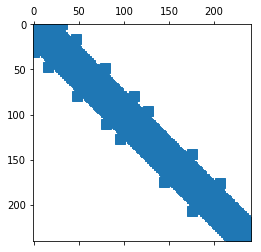

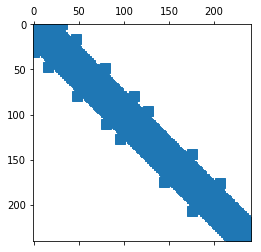

In [1]:
import scipy.sparse
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import pylab as pl
import scipy as sp
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import healpy as hp


bw = 8
npix = 2*bw*(2*bw-1)+1

L = scipy.sparse.load_npz('matrices/stiffness_matrix_{}.npz'.format(bw))
B = scipy.sparse.load_npz('matrices/mass_matrix_{}.npz'.format(bw))
reordering_mask = np.load("15_reordering_masks/reordering_mask_{}.npy".format(bw))

L = L[reordering_mask]
B = B[reordering_mask]
L = L[:, reordering_mask]
B = B[:, reordering_mask]
B_inv = scipy.sparse.linalg.inv(B)
signal = np.zeros(npix)
signal[0] = 1

B_lumped_inverse = np.diag(1./np.sum(B.toarray(), axis=1))


plt.spy(L)
plt.show()
plt.spy(B)
plt.show()

In [2]:
def subplotsphere(fig, signal, coords, tri, j):
    ax = fig.add_subplot(2,2,j+1, projection='3d')
    M = np.max(signal)
    for simplex in tri.simplices:
        triangle = a3.art3d.Poly3DCollection([coords[simplex]])
        triangle.set_color(colors.rgb2hex([np.max(signal[simplex])/M, 0,0]))
        triangle.set_edgecolor('k')
        ax.add_collection3d(triangle)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    
    

# FEM diffusion


In [3]:
class Equiangulartovtk:
     
    def make_coords(self, bw):
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        return coords[2*bw-1:]

    def __init__(self, bw=4):
        from pyevtk.hl import unstructuredGridToVTK
        from pyevtk.vtk import VtkTriangle, VtkQuad
        
        self.coords = self.make_coords(bw)
        self.x = self.coords[:,0]
        self.y = self.coords[:,1]
        self.z = self.coords[:,2]
        width = 2*bw
        
        
        tri = []
        # north pole
        for i in range(width):
            tri.append([0, i+1, (i+1)%width+1])
        
        # inner layers
        for j in range(width-2):
            s = j*width  # s stands for "shift"
            for i in range(width):
                tri.append([s + (i+1), s + (i+1)%width+1, s + (i+1)%width+1 + width])
            for i in range(width):
                tri.append([s + (i+1), s + (i+1) + width, s + (i+1)%width + width + 1])
                
       
        npix = width*(width-1)+1
        last_row = np.arange(npix-width, npix)
        start = last_row[0]
        for i in last_row[:-2]:
            tri.append([start, i+1, i+2])
        
        
        self.simplices = np.asarray(tri)
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid

    def save(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})
            
            
e = Equiangulartovtk(bw)

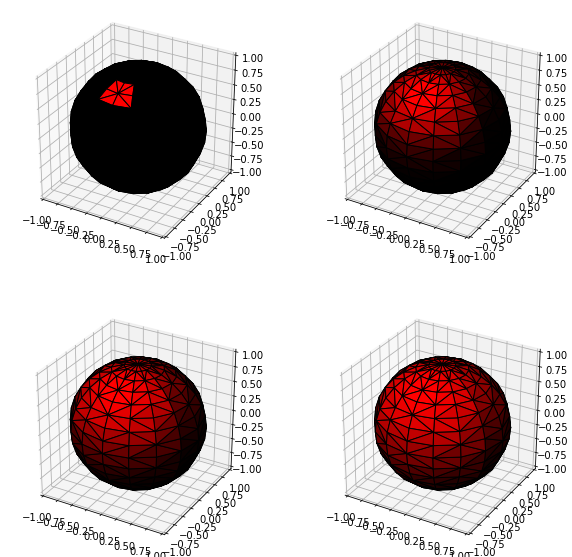

In [7]:
M = scipy.linalg.expm(-0.08*B_inv@L)
M_lumped = scipy.linalg.expm(-0.08*B_lumped_inverse@L)

def diffuse(x):
    return M@x

def diffuse_lumped(x):
    return M_lumped@x

def create_coords(bw):
    alpha = np.arange(2 * bw) * np.pi / bw
    beta = np.arange(2 * bw) * np.pi / (2. * bw)
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta).flatten()
    st = np.sin(theta).flatten()
    cp = np.cos(phi).flatten()
    sp = np.sin(phi).flatten()
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x, y, z]).T
    coords = np.asarray(coords, dtype=np.float32)
    coords = coords[2*bw-1:]
    return coords

fig = plt.figure(figsize=(10,10))

signal = np.zeros(npix)
signal[45] = 1
indexes = range(npix)
coords = create_coords(bw)

tri = ConvexHull(coords)  # just for plotting

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(1):
        signal = np.asarray(abs(diffuse(signal)))
    e.save('17_diffusion_img/FEM_diffusion000000{}'.format(j), pointData = signal)
plt.savefig('17_diffusion_img/FEM_diffusion')


# GRAPH diffusion

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


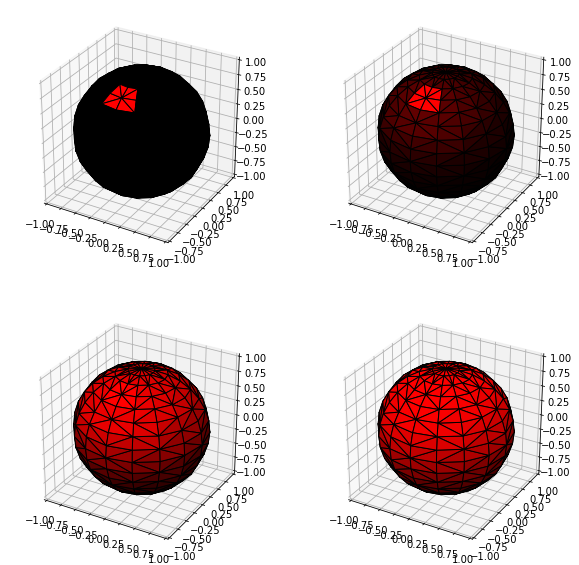

In [6]:
from pygsp.graphs import Graph
# re initializing the signal to diffuse
signal = np.zeros(npix)
signal[45] = 1
fig = plt.figure(figsize=(10,10))


class FullSphereEquiangular(Graph):
    """Modified from the class implemented by Droxef
    https://github.com/Droxef/PDMdeepsphere/
    """
    sigmas = {4:0.5,
              8:0.3,
              16: 0.1, 
              32: 0.03,
              64: 0.01}
    
    def __init__(self, bw=64):
       
        self.bw = bw

        ## sampling and coordinates calculation
        alpha = np.arange(2 * bw) * np.pi / bw
        beta = np.arange(2 * bw) * np.pi / (2. * bw)
      
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        coords = coords[2*bw-1:]
        
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        W = np.exp(-distances_squared/self.sigmas[bw])
        W = W-np.diag(np.diag(W))
        super(FullSphereEquiangular, self).__init__(W=W, coords=coords)

graph = FullSphereEquiangular(bw)
HKGL = graph.L

def diffuse_HKGL(x):
    return scipy.linalg.expm(-0.05*HKGL)@x

for j in range(4):
    
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(3):
        signal = diffuse_HKGL(signal)

plt.savefig('17_diffusion_img/GRAPH_diffusion')